Mounted at /content/drive
/content
/content/drive/MyDrive/kaushikSAR
successfully imported required libraries
/content/drive/MyDrive
dem shape: (1770, 1475)
slope shape: (1770, 1475)
ndvi shape: (1770, 1476)
rgb shape: (1770, 1476, 3)


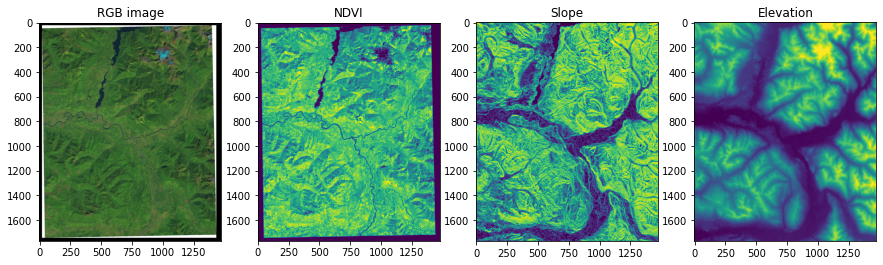

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
print(os.getcwd())
os.chdir('/content/drive/MyDrive/kaushikSAR')
print(os.getcwd())
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import h5py
import os
import glob
print("successfully imported required libraries")
import tensorflow as tf
from tensorflow.keras import backend as K
# recall 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
from tensorflow import keras
os.chdir('/content/drive/MyDrive')
print(os.getcwd())
model = keras.models.load_model("model_save.h5", custom_objects={'f1_m':f1_m, 'precision_m':precision_m, 'recall_m':recall_m })
os.chdir('/content/drive/MyDrive/kaushikSAR')
dem = mpimg.imread("mydem.tif")
slope = mpimg.imread("myslope.tif")
ndvi = mpimg.imread("myndvi.tif")
rgb = mpimg.imread("rgb.tif")
print("dem shape:", dem.shape)      
print("slope shape:", slope.shape)  
print("ndvi shape:", ndvi.shape)    
print("rgb shape:", rgb.shape) 
k = mpimg.imread("osooutput.png")
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))
ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax1.imshow(rgb)
ax2.imshow(ndvi)
ax3.imshow(slope)
ax4.imshow(dem)     

dem shape: (128, 128)
slope shape: (128, 128)
ndvi shape: (128, 128)
rgb shape: (128, 128, 3)


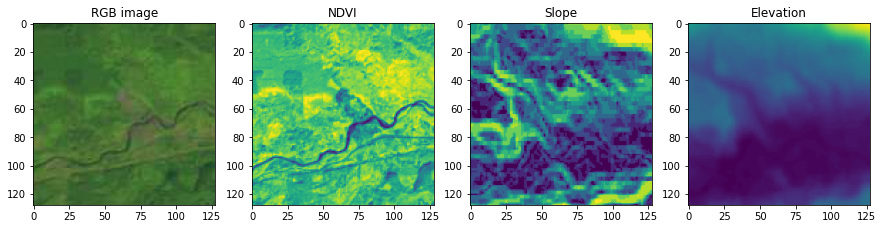

In [2]:
dem1 = dem[1600:1728,160:288 ]
slope1 = slope[1600:1728,160:288]
ndvi1 = ndvi[1600:1728,160:288]
rgb1 = rgb[1600:1728,160:288]
print("dem shape:", dem1.shape)      
print("slope shape:", slope1.shape)  
print("ndvi shape:", ndvi1.shape)    
print("rgb shape:", rgb1.shape)   
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))
ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax1.imshow(rgb1)
ax2.imshow(ndvi1)
ax3.imshow(slope1)
ax4.imshow(dem1)
#oso landslide

(1, 128, 128, 6)
1/1 [==============================] - 1s 620ms/step
(1, 128, 128, 1)


Text(0.5, 1.0, 'Image')

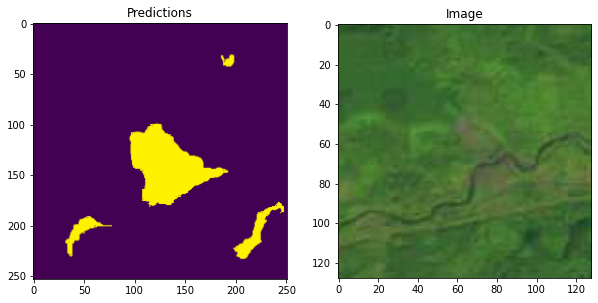

In [3]:
VAL_XX = np.zeros((1, 128, 128, 6))
mid_rgb = rgb[:, :, 0:3].max() / 2.0
VAL_XX[0, :, :, 0] = 1 - rgb1[:, :, 2] / mid_rgb #RED
VAL_XX[0, :, :, 1] = 1 - rgb1[:, :, 1] / mid_rgb #GREEN
VAL_XX[0, :, :, 2] = 1 - rgb1[:, :, 0] / mid_rgb #BLUE
VAL_XX[0, :, :, 3] = ndvi1 #NDVI
VAL_XX[0, :, :, 4] = 1- slope1 / slope1.max()/2.0 #SLOPE
VAL_XX[0, :, :, 5] = 1 - dem1 / dem1.max() / 2.0 #ELEVATION
print(VAL_XX.shape)
pred_img = model.predict(VAL_XX)
pred_img = (pred_img ).astype(np.uint8)
print(pred_img.shape)
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,5))
ax1.imshow(k)
ax1.set_title("Predictions")
ax2.imshow(rgb[1600:1728,160:288])
ax2.set_title('Image')
#fig.savefig("a")

### **Thank You**

In [4]:
def listitems(n):
  validation_url = r'/content/drive/MyDrive/Valid/img/image_'+n+'.h5'
  img_val = sorted(glob.glob(validation_url))
  print(img_val)
  VAL_XX = np.zeros((1, 128, 128, 6))
  mask_name = []
  for i, img in enumerate(img_val):
      print(i, img)
      mask_name.append(img.split('/')[-1].replace('image', 'mask'))
      with h5py.File(img) as hdf:
          ls = list(hdf.keys())
          data = np.array(hdf.get('img'))

          # assign 0 for the nan value
          data[np.isnan(data)] = 0.000001

          # to normalize the data 
          mid_rgb = data[:, :, 1:4].max() / 2.0
          mid_slope = data[:, :, 12].max() / 2.0
          mid_elevation = data[:, :, 13].max() / 2.0

          # ndvi calculation
          data_red = data[:, :, 3]
          data_nir = data[:, :, 7]
          data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
          
          # final array
          VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
          VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
          VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
          VAL_XX[i, :, :, 3] = data_ndvi #NDVI
          VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
          VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
  print(VAL_XX.shape)
  return VAL_XX  
  

Enter the number of the file: 9
['/content/drive/MyDrive/Valid/img/image_9.h5']
0 /content/drive/MyDrive/Valid/img/image_9.h5
(1, 128, 128, 6)
(1, 128, 128, 6)
1/1 [==============================] - 0s 63ms/step


(1, 128, 128, 1)


Text(0.5, 1.0, 'Mask')

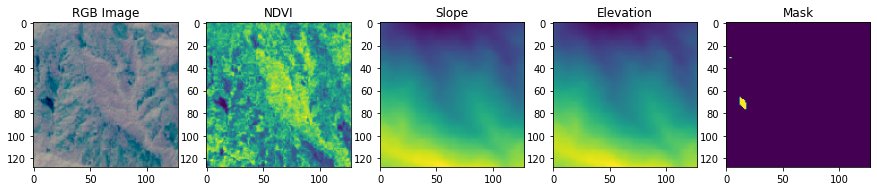

In [22]:
n = input("Enter the number of the file: ")
threshold = 0.5
VAL_XX = listitems(n)
print(VAL_XX.shape)
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
print(pred_img.shape)

fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(1,5,figsize=(15,10))
ax1.imshow(VAL_XX[0, :, :, 0:3])
ax1.set_title("RGB Image")
ax2.imshow(VAL_XX[0, :, :, 3])
ax2.set_title("NDVI")
ax3.imshow(VAL_XX[0, :, :, 4])
ax3.set_title("Slope")
ax4.imshow(VAL_XX[0, :, :, 5])
ax4.set_title("Elevation")
ax5.imshow(pred_img[0, :, :, 0])
ax5.set_title('Mask')

In [ ]:
44,162,199,53,29,60,129,9(minor)

##Thank you